# Comp 4211 PA 3
## Fake News Detection using Recurrent Neural Network
### Lee Jae Yeol (20308109)  |  jyleeag@connect.ust.hk

## Outline of the Assignment
### 1. Dataset and Dataloader
### 2. Recurrent Neural Network Baseline Model

### 3. Training and Validation
### 4. Empirical Study
> * 4.1 GRU
> * 4.2 LSTM
> * 4.3 LSTM - Bidirectional

### 5. Performance Enhancement
> * 5.1 (B) Model Weight Initialization
> * 5.2 (D) Model Ensemble
### 6. Test Set Prediction


In [349]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

PATH = '/content/drive/MyDrive/Colab Notebooks/PA3/'

Mounted at /content/drive


In [350]:
#!pip uninstall torch torchvision -y
#!pip install torch torchvision
#pip install -U torchtext==0.8.0

In [351]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch, torchvision, torchsummary
import torch.nn as nn
from torch.optim import Adam
from torchtext.legacy.data import Field, TabularDataset, BucketIterator

import nltk
nltk.download('punkt')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [352]:
print(torch.__version__)
print(torchvision.__version__)

1.8.1+cu101
0.9.1+cu101


In [353]:
# check GPU support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## 1. Dataset and DataLoader

In [354]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'test.csv')

In [355]:
train.head()

,label,text
0,0,"Toots Thielemans, Who Won Jazz Renown With the..."
1,0,‘The Greatest Loss and Despair’: Thais Mourn T...
2,0,George Will Leaves the G.O.P. Over Donald Trump
3,0,Rafael Nadal Upset by Lucas Pouille in Fourth ...
4,0,"Hollywood Holiday Habits: Big Games, Small Gif..."


In [356]:
print("Check train.csv Null values", train.isna().sum())
print("Check train.csv duplicated values:", train.duplicated().sum())
print("Number of Label 0 : Real",(train['label'] == 0).sum()) # 0 : Real
print("Number of Label 1 : Fake ",(train['label'] == 1).sum()) # 1 : Fake

Check train.csv Null values label    0
text     0
dtype: int64
Check train.csv duplicated values: 57
Number of Label 0 : Real 9375
Number of Label 1 : Fake  3000


Duplicated values do not need to be dropped.

In [357]:
train_for_split = train.copy()
random_label0 = train_for_split[train_for_split['label'] == 0].sample(n = 3000, random_state = 4211)
train_split = random_label0.append(train_for_split[train_for_split['label'] == 1])

`remain_label0` is the additional label0 train set data that needs to be appended to the `x_train` and `y_train` from the `train_test_split`.

In [358]:
remain_label0 = train_for_split[~train_for_split.index.isin(train_split.index)]

In [359]:
## The hold-out method is good to use when you have a very large dataset, you’re on a time crunch, or you are starting to build an initial model.
x_train, x_valid, y_train, y_valid = train_test_split(
            train_split['text'], train_split['label'], test_size = 1/3, random_state = 4211, stratify = train_split['label'])

Append has been performed after the train_test_split for equal balance of the data classes which is the underlying purpose for this method.

In [360]:
x_train = x_train.append(remain_label0.text)
y_train = y_train.append(remain_label0.label)

print("train set len:",len(y_train))
# y_train.value_counts()
print("train set label 0 size:", len(y_train[y_train == 0]))
print("train set label 1 size:", len(y_train[y_train == 1]))
print("valid set len:",len(y_valid))
print("valid set label 0 size:", len(y_valid[y_valid == 0]))
print("valid set label 1 size:", len(y_valid[y_valid == 1]))

train set len: 10375
train set label 0 size: 8375
train set label 1 size: 2000
valid set len: 2000
valid set label 0 size: 1000
valid set label 1 size: 1000


In [361]:
modified_trainset = pd.DataFrame(x_train).assign(label = y_train) #.to_csv("modified_trainset.csv")
modified_validset = pd.DataFrame(x_valid).assign(label = y_valid) #.to_csv("modified_validset.csv")
modified_testset = test[['text', 'label']]
modified_trainset.to_csv(PATH+ "modified_trainset.csv", index= False)
modified_validset.to_csv(PATH+ "modified_validset.csv", index= False)
modified_testset.to_csv(PATH+ "modified_testset.csv", index= False)

In [362]:
txt_field = Field(tokenize = word_tokenize, lower = True, batch_first=True, include_lengths=True)
label_field = Field(sequential = False, use_vocab = False, batch_first=True)

train, valid, test = TabularDataset.splits(path = PATH, train = 'modified_trainset.csv', validation = 'modified_validset.csv', test = 'modified_testset.csv',
                              format = 'csv', fields = [('sentence', txt_field), ('label', label_field)], skip_header = True)

txt_field.build_vocab(train, min_freq = 2) 

# loading an iterator
train_iter, valid_iter, test_iter = BucketIterator.splits(
     (train,valid, test), batch_size = 64, sort_key = lambda x: len(x.sentence), 
     sort_within_batch = True, device = device )


In [363]:
print(f'Number of Training samples: {len(train.examples)}')
print(f'Example of Training data:\n {vars(train.examples[0])}\n')

print(f'Number of Validation samples: {len(valid.examples)}')
print(f'Example of validation data:\n {vars(valid.examples[1])}\n')

Number of Training samples: 10375
Example of Training data:
 {'sentence': ['report', ':', 'leakers', 'found', 'inside', 'white', 'house', ',', 'trump', 'will', 'be', 'firing'], 'label': '0'}

Number of Validation samples: 2000
Example of validation data:
 {'sentence': ['90', 'year-old', 'former', 'greek', 'president', 'constantine', 'stephanopoulos', 'dies'], 'label': '1'}



In [364]:
#print(txt_field.vocab[100])
print(txt_field.vocab.freqs.most_common(10))
print(txt_field.vocab.stoi)

[('’', 6414), (',', 3590), (':', 2963), ('to', 2848), ('the', 2420), ('in', 2173), ('trump', 2053), ('of', 1934), ('s', 1926), ('a', 1659)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fb2c450c790>>, {'<unk>': 0, '<pad>': 1, '’': 2, ',': 3, ':': 4, 'to': 5, 'the': 6, 'in': 7, 'trump': 8, 'of': 9, 's': 10, 'a': 11, 'for': 12, 'and': 13, '‘': 14, 'on': 15, 'is': 16, '.': 17, 'at': 18, 'with': 19, 'donald': 20, '?': 21, 'as': 22, 'new': 23, 'by': 24, 'clinton': 25, 'from': 26, 'hillary': 27, 'it': 28, 'after': 29, 'your': 30, 'not': 31, 'over': 32, 'will': 33, 'are': 34, 'obama': 35, 't': 36, 'you': 37, 'how': 38, 'be': 39, 'what': 40, 'says': 41, 'that': 42, 'news': 43, 'his': 44, 'u.s.': 45, 'an': 46, 'i': 47, 'about': 48, 'russia': 49, 'house': 50, 'president': 51, 'state': 52, 'election': 53, '-': 54, 'up': 55, 'have': 56, 'we': 57, 'no': 58, 'white': 59, 'who': 60, 'briefing': 61, '!': 62, 'he': 63, 'this': 64, '$': 65, 'out': 66, 'police'

In [365]:
train_oov = 0
train_vocab = 0
valid_oov = 0
valid_vocab = 0

for index in range(len(train.examples)):
  item = vars(train.examples[index])['sentence']
  for index2 in range(len(item)):
    if txt_field.vocab[item[index2]] == 0:
      train_oov += 1
    else:
      train_vocab += 1

for index in range(len(valid.examples)):
  item = vars(valid.examples[index])['sentence']
  for index2 in range(len(item)):
    if txt_field.vocab[item[index2]] == 0:
      valid_oov += 1
    else:
      valid_vocab += 1

print("train_oov count:", train_oov)
print("valid_oov count:", valid_oov)

print("train_vocab count:", train_vocab)
print("valid_vocab count:", valid_vocab)

train_oov count: 8662
valid_oov count: 3020
train_vocab count: 119106
valid_vocab count: 22233


In [366]:
len(txt_field.vocab)

7929

Build the vocabulary on the training set only

###[Q1] 
Report the number of out-of-vocabulary (OOV) words in your training set and validation
set, respectively. How does the torchtext library tackle the OOV words?

Out of Vocabulary refers to words in the training or validation dataset that aren't present in the vocabulary list, which in our case is built solely on subsets of training data. Torchtext library from Pytorch handles OOV issues by replacing unseen words with the token `<unk>`. 

## 2. Recurrent Neural Network Baseline Model

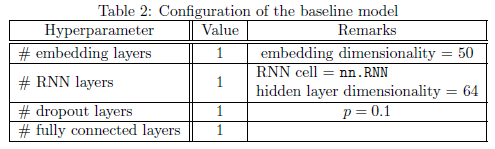

1. Init: Whenever an instance of a class is created, init function is automatically invoked. Hence, it is called as a constructor. The arguments passed to the class are initialized by the constructor.We will define all the layers that we will be using in the model

2. Forward: Forward function defines the forward pass of the inputs.

3. Embedding layer: Embeddings are extremely important for any NLP related task since it represents a word in a numerical format. Embedding layer creates a look up table where each row represents an embedding of a word. The embedding layer converts the integer sequence into a dense vector representation. Here are the two most important parameters of the embedding layer * num_embeddings: No. of unique words in dictionary. * embedding_dim:  No. of dimensions for representing a word

* input_size  :  Dimension of input
* hidden_size :  Number of hidden nodes
* num_layers  :  Number of layers to be stacked
* batch_first  : If True, then the input and output tensors are provided as (batch, seq, feature)
* dropout: If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0

4. Linear Layer: Linear layer refers to dense layer. The two important parameters here are described below: in_features : No. of input features
out_features: No. of hidden nodes

5. Pack Padding: As already discussed, pack padding is used to define the dynamic recurrent neural network. Without pack padding, the padding inputs are also processed by the rnn and returns the hidden state of the padded element. This an awesome wrapper that does not show the inputs that are padded. It simply ignores the values and returns the hidden state of the non padded element.

reference : [text-classification-in-pytorch](https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/)

In [367]:
class RNN0(nn.Module):
  def __init__(self, n_vocab, embedding_dim, hidden_dim, n_layers, dropout = 0):
    super(RNN0, self).__init__()                 #constructor
    self.emb = nn.Embedding(n_vocab, embedding_dim)  #embedding layer
    self.rnn = nn.RNN(                               #baseline RNN layer
        input_size = embedding_dim,
        hidden_size = hidden_dim,
        num_layers = n_layers,
        #dropout = dropout,
        batch_first = True
    )
    self.dropout =  nn.Dropout(p = 0.1)
    self.fc = nn.Linear(hidden_dim, 1)  #binary classification

  def forward(self, sent, sent_len):
    # sent : [batch_size, max_sent_len]
    # sent_len : [batch_size]
    sent_emb = self.emb(sent)  #[batch_size, max_sent_len, embedding_dim]

    #Underscore(_) is also used to ignore the values. If you don't want to use specific values while unpacking, just assign that value to underscore(_).
    packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first = True)
    packed_outputs, hidden = self.rnn(packed_embedded)
    out, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first= True)

    out = self.dropout(out)
    out = self.fc(out)
    out = out.view(out.size(0), -1)

    return out

In [368]:
n_vocab = len(txt_field.vocab)
embedding_dim = 50
hidden_dim = 64
n_layers = 1
dropout = 0.1
rnn0 = RNN0(n_vocab, embedding_dim, hidden_dim, n_layers, dropout)

###[Q2] 
"Print" the model architecture and the number of trainable parameters for the baseline model and include them in the written report.

In [369]:
!pip install torchsummaryX
from torchsummaryX import summary
summary(rnn0, torch.zeros((64,10), dtype=torch.long),torch.ones((64,), dtype=torch.long))

          Kernel Shape  Output Shape   Params Mult-Adds
Layer                                                  
0_emb       [50, 7929]  [64, 10, 50]  396.45k   396.45k
1_rnn                -      [64, 64]   7.424k    7.296k
2_dropout            -   [64, 1, 64]        -         -
3_fc           [64, 1]    [64, 1, 1]     65.0      64.0
---------------------------------------------------------
                        Totals
Total params          403.939k
Trainable params      403.939k
Non-trainable params       0.0
Mult-Adds              403.81k


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_emb,"[50, 7929]","[64, 10, 50]",396450.0,396450.0
1_rnn,-,"[64, 64]",7424.0,7296.0
2_dropout,-,"[64, 1, 64]",NaN,NaN
3_fc,"[64, 1]","[64, 1, 1]",65.0,64.0


In [370]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

403939

## 3. Training and Validation

In [371]:
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to {save_path}')

def load_checkpoint(save_path, model, optimizer):
    save_path = save_path 
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from {save_path}, with val loss: {val_loss}')
    return val_loss

In [372]:
PRE_THRESH = 0.5    # pre define a constant threshold 0.5

def Train(model, train_loader, valid_loader, n_epochs, criterion, optimizer, val_loss, device, save_name):
  if val_loss==None:
    best_val_loss = float("Inf")  
  else: 
    best_val_loss=val_loss
    print('Resume training')

  model.to(device)
    
  print("Start Training")
  train_loss_score = []
  valid_loss_score = []
  best_val_score = 0

  for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for data in train_loader:
      label = data.label
      input, sen_len = data.sentence
      label = label.to(device)
      input = input.to(device)

      ''' Model Train Step'''
      # Forward
      output = model(input, sen_len)
      output = torch.mean(output, 1) 
      loss = criterion(output, label.float())

      # Backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_score.append(train_loss)

    with torch.no_grad():
      model.eval()
      valid_running_loss = 0.0
      correct_count = 0
      for data in valid_loader:
        label = data.label
        input, sen_len = data.sentence
        label = label.to(device)
        input = input.to(device)

        ''' Model Train Step'''
        # eval
        output = model(input, sen_len)
        output = torch.mean(output, 1)
        loss = criterion(output, label.float())
        valid_running_loss += loss.item()

        prediction = output >= torch.FloatTensor([PRE_THRESH]).to(device)
        correct_prediction = prediction.float() == label
        correct_count += torch.sum(correct_prediction) 

      valid_loss = valid_running_loss / len(valid_loader)
      valid_loss_score.append(valid_loss)
      accuracy = correct_count / len(valid_loader)
      if accuracy > best_val_score:
        best_val_score = accuracy

      print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'
      .format(epoch+1, n_epochs, train_loss, valid_loss, accuracy / 100))

    # if valid_loss < best_val_loss:
    #           best_val_loss = valid_loss
    #           save_checkpoint(save_name, model, optimizer, best_val_loss)
                  
  print('Finished Training')
  print('Best Validation Accuracy Score: {:.4f}', best_val_score.item() / 100)
  return train_loss_score, valid_loss_score, best_val_score.item()/ 100


In [374]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

n_vocab = len(txt_field.vocab)
embedding_dim = 50
hidden_dim = 64
n_layers = 1
dropout = 0.1
rnn0 = RNN0(n_vocab, embedding_dim, hidden_dim, n_layers, dropout)

n_epochs = 15
val_loss = None
save_name = 'rnn_model'
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(rnn0.parameters())
dropout = 0.1

rnn0train, rnn0valid, rnn0score = Train(rnn0, train_iter, valid_iter, n_epochs, criterion, optimizer, val_loss, device, dropout)

cpu
Start Training
Epoch [1/15], Train Loss: 0.4717, Valid Loss: 0.7460, Valid Acc: 0.3212
Epoch [2/15], Train Loss: 0.4002, Valid Loss: 0.7090, Valid Acc: 0.3622
Epoch [3/15], Train Loss: 0.3456, Valid Loss: 0.6231, Valid Acc: 0.3925
Epoch [4/15], Train Loss: 0.3013, Valid Loss: 0.7228, Valid Acc: 0.4072
Epoch [5/15], Train Loss: 0.2628, Valid Loss: 0.5595, Valid Acc: 0.4516
Epoch [6/15], Train Loss: 0.2208, Valid Loss: 0.6465, Valid Acc: 0.4419
Epoch [7/15], Train Loss: 0.1878, Valid Loss: 0.5847, Valid Acc: 0.4534
Epoch [8/15], Train Loss: 0.1586, Valid Loss: 0.6427, Valid Acc: 0.4641
Epoch [9/15], Train Loss: 0.1304, Valid Loss: 0.6015, Valid Acc: 0.4703
Epoch [10/15], Train Loss: 0.1091, Valid Loss: 0.5591, Valid Acc: 0.4772
Epoch [11/15], Train Loss: 0.0861, Valid Loss: 0.8278, Valid Acc: 0.4769
Epoch [12/15], Train Loss: 0.0712, Valid Loss: 0.8612, Valid Acc: 0.4703
Epoch [13/15], Train Loss: 0.0524, Valid Loss: 0.8299, Valid Acc: 0.4819
Epoch [14/15], Train Loss: 0.0429, Valid 

Plot function for train & valid loss

In [437]:
def plot(model_type, train_loss, valid_loss):
  plt.plot(train_loss, label = 'training loss')
  plt.plot(valid_loss, label = 'validation loss')
  plt.title(model_type + ': Training & Validation Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.grid('on')
  plt.show()

[Q3] Paste the screenshot of the plot and report the best validation accuracy of the baseline
model.

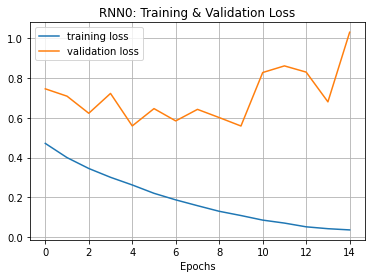

In [438]:
plot("RNN0", rnn0train, rnn0valid)

### 4. Empirical Study 
#### Different RNN Settings

[Q4] List two advantages of using GRU and LSTM when compared to the baseline RNN
model.

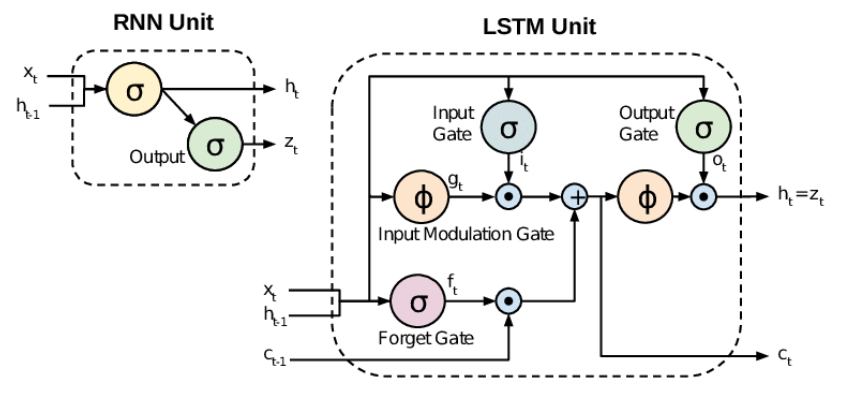

image source: [stack exchange](https://stats.stackexchange.com/questions/222584/difference-between-feedback-rnn-and-lstm-gru/222587#:~:text=All%20RNNs%20have%20feedback%20loops,in%20'memory'%20over%20time.&text=LSTM%20networks%20are%20a%20type,for%20long%20periods%20of%20time.)
<br>
The crucial difference between RNN model and LSTM/GRU is that the posterior models have a 'memory cell' that holds the information from the past layers of the model. Therefore, LSTM/GRU models have access to long-term information, much more efficient than RNN model when the past information is important or when the sequential input is large. 
Another advantage 'memory cell' has is that it makes the model less vulnerable to vanishing gradient problems, with the same reason as above. 

In [377]:
class GRU1(nn.Module):
  def __init__(self, n_vocab, embedding_dim, hidden_dim, n_layers, dropout = 0):
    super(GRU1, self).__init__()                    
    self.emb = nn.Embedding(n_vocab, embedding_dim) 
    self.rnn = nn.GRU(                               
        input_size = embedding_dim,
        hidden_size = hidden_dim,
        num_layers = n_layers,
        batch_first = True
    )
    self.dropout =  nn.Dropout(p = 0.1)
    self.fc = nn.Linear(hidden_dim, 1) 

  def forward(self, sent, sent_len):
    sent_emb = self.emb(sent)  

    packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first = True)
    packed_outputs, hidden = self.rnn(packed_embedded)
    out, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first= True)

    out = self.dropout(out)
    out = self.fc(out)
    out = out.view(out.size(0), -1)

    return out


In [378]:
gru1 = GRU1(n_vocab, embedding_dim, hidden_dim, n_layers, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(gru1.parameters())

gru1train, gru1valid, gru1score = Train(gru1, train_iter, valid_iter, n_epochs, criterion, optimizer, val_loss, device, dropout)

Start Training
Epoch [1/15], Train Loss: 0.4777, Valid Loss: 0.8067, Valid Acc: 0.3197
Epoch [2/15], Train Loss: 0.3950, Valid Loss: 0.5967, Valid Acc: 0.3919
Epoch [3/15], Train Loss: 0.3320, Valid Loss: 0.7084, Valid Acc: 0.4006
Epoch [4/15], Train Loss: 0.2739, Valid Loss: 0.5976, Valid Acc: 0.4437
Epoch [5/15], Train Loss: 0.2280, Valid Loss: 0.5381, Valid Acc: 0.4575
Epoch [6/15], Train Loss: 0.1934, Valid Loss: 0.5494, Valid Acc: 0.4731
Epoch [7/15], Train Loss: 0.1634, Valid Loss: 0.5553, Valid Acc: 0.4812
Epoch [8/15], Train Loss: 0.1306, Valid Loss: 0.5483, Valid Acc: 0.4888
Epoch [9/15], Train Loss: 0.1013, Valid Loss: 0.6183, Valid Acc: 0.4888
Epoch [10/15], Train Loss: 0.0794, Valid Loss: 0.7035, Valid Acc: 0.4797
Epoch [11/15], Train Loss: 0.0579, Valid Loss: 0.7110, Valid Acc: 0.4825
Epoch [12/15], Train Loss: 0.0432, Valid Loss: 0.8289, Valid Acc: 0.4803
Epoch [13/15], Train Loss: 0.0319, Valid Loss: 0.9022, Valid Acc: 0.4891
Epoch [14/15], Train Loss: 0.0261, Valid Loss

In [379]:
class LSTM2(nn.Module):
  def __init__(self, n_vocab, embedding_dim, hidden_dim, n_layers, dropout = 0):
    super(LSTM2, self).__init__()                    
    self.emb = nn.Embedding(n_vocab, embedding_dim) 
    self.rnn = nn.LSTM(                               
        input_size = embedding_dim,
        hidden_size = hidden_dim,
        num_layers = n_layers,
        batch_first = True
    )
    self.dropout =  nn.Dropout(p = 0.1)
    self.fc = nn.Linear(hidden_dim, 1) 

  def forward(self, sent, sent_len):
    sent_emb = self.emb(sent)  

    packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first = True)
    packed_outputs, hidden = self.rnn(packed_embedded)
    out, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first= True)

    out = self.dropout(out)
    out = self.fc(out)
    out = out.view(out.size(0), -1)

    return out

In [380]:
lstm2 = LSTM2(n_vocab, embedding_dim, hidden_dim, n_layers, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer2 = Adam(lstm2.parameters())

lstm2train, lstm2valid, lstm2score = Train(lstm2, train_iter, valid_iter, n_epochs, criterion, optimizer2, val_loss, device, dropout)

Start Training
Epoch [1/15], Train Loss: 0.4954, Valid Loss: 0.7997, Valid Acc: 0.3125
Epoch [2/15], Train Loss: 0.4117, Valid Loss: 0.7288, Valid Acc: 0.3241
Epoch [3/15], Train Loss: 0.3459, Valid Loss: 0.6619, Valid Acc: 0.3931
Epoch [4/15], Train Loss: 0.2794, Valid Loss: 0.5426, Valid Acc: 0.4469
Epoch [5/15], Train Loss: 0.2333, Valid Loss: 0.5664, Valid Acc: 0.4531
Epoch [6/15], Train Loss: 0.1964, Valid Loss: 0.5245, Valid Acc: 0.4750
Epoch [7/15], Train Loss: 0.1632, Valid Loss: 0.6561, Valid Acc: 0.4478
Epoch [8/15], Train Loss: 0.1333, Valid Loss: 0.6574, Valid Acc: 0.4712
Epoch [9/15], Train Loss: 0.1072, Valid Loss: 0.6659, Valid Acc: 0.4831
Epoch [10/15], Train Loss: 0.0912, Valid Loss: 0.8103, Valid Acc: 0.4659
Epoch [11/15], Train Loss: 0.0686, Valid Loss: 0.8080, Valid Acc: 0.4772
Epoch [12/15], Train Loss: 0.0561, Valid Loss: 0.8832, Valid Acc: 0.4831
Epoch [13/15], Train Loss: 0.0421, Valid Loss: 0.9334, Valid Acc: 0.4734
Epoch [14/15], Train Loss: 0.0335, Valid Loss

[Q5] Plot the training and validation losses of the baseline model, model 1 and model 2 in one plot
and report the best validation accuracy of each model. Does the result follow your expectation
in Q4? If not, suggest some possible reason(s).

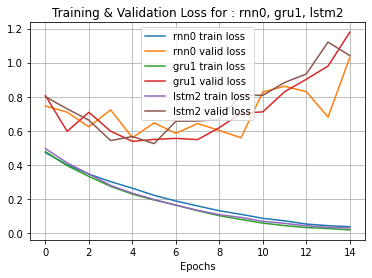

In [381]:
plt.plot(rnn0train, label = 'rnn0 train loss')
plt.plot(rnn0valid, label = 'rnn0 valid loss')
plt.plot(gru1train, label = 'gru1 train loss')
plt.plot(gru1valid, label = 'gru1 valid loss')
plt.plot(lstm2train, label = 'lstm2 train loss')
plt.plot(lstm2valid, label = 'lstm2 valid loss')
plt.title('Training & Validation Loss for : rnn0, gru1, lstm2')
plt.xlabel('Epochs')
plt.grid('on')
plt.legend()
plt.show()

As expected, the GRU and LSTM models output a higher validation accuracy score compared to the baseline RNN model. The two model shows faster convergence, meaning that with the same number of epochs, it might lead to overfitting.

In [382]:
class LSTM3(nn.Module):
  def __init__(self, n_vocab, embedding_dim, hidden_dim, n_layers, dropout = 0):
    super(LSTM3, self).__init__()                    
    self.emb = nn.Embedding(n_vocab, embedding_dim) 
    self.rnn = nn.LSTM(                               
        input_size = embedding_dim,
        hidden_size = hidden_dim,
        num_layers = n_layers,
        batch_first = True,
        bidirectional = True
    )
    self.dropout =  nn.Dropout(p = 0.1)
    self.fc = nn.Linear(hidden_dim * 2, 1) 

  def forward(self, sent, sent_len):
    sent_emb = self.emb(sent)  

    packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first = True)
    packed_outputs, hidden = self.rnn(packed_embedded)
    out, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first= True)

    out = self.dropout(out)
    out = self.fc(out)
    out = out.view(out.size(0), -1)

    return out

In [384]:
lstm3 = LSTM3(n_vocab, embedding_dim, hidden_dim, n_layers, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(lstm3.parameters())

lstm3train, lstm3valid, lstm3score = Train(lstm3, train_iter, valid_iter, n_epochs, criterion, optimizer, val_loss, device, dropout)

Start Training
Epoch [1/15], Train Loss: 0.4714, Valid Loss: 0.7644, Valid Acc: 0.3197
Epoch [2/15], Train Loss: 0.3719, Valid Loss: 0.5234, Valid Acc: 0.4547
Epoch [3/15], Train Loss: 0.2882, Valid Loss: 0.4723, Valid Acc: 0.4766
Epoch [4/15], Train Loss: 0.2365, Valid Loss: 0.4905, Valid Acc: 0.4812
Epoch [5/15], Train Loss: 0.1916, Valid Loss: 0.5360, Valid Acc: 0.4784
Epoch [6/15], Train Loss: 0.1550, Valid Loss: 0.5166, Valid Acc: 0.4947
Epoch [7/15], Train Loss: 0.1207, Valid Loss: 0.6057, Valid Acc: 0.5000
Epoch [8/15], Train Loss: 0.0876, Valid Loss: 0.6933, Valid Acc: 0.4931
Epoch [9/15], Train Loss: 0.0648, Valid Loss: 0.7929, Valid Acc: 0.4884
Epoch [10/15], Train Loss: 0.0456, Valid Loss: 0.9407, Valid Acc: 0.4897
Epoch [11/15], Train Loss: 0.0255, Valid Loss: 0.9080, Valid Acc: 0.4963
Epoch [12/15], Train Loss: 0.0188, Valid Loss: 1.1200, Valid Acc: 0.4916
Epoch [13/15], Train Loss: 0.0187, Valid Loss: 1.2539, Valid Acc: 0.4844
Epoch [14/15], Train Loss: 0.0138, Valid Loss

[Q6] Plot the training and validation losses of model 2 and model 3 in one plot and report the best
validation accuracy of each model. Briefly explain the effect of adding the backward direction in the bidirectional LSTM compared to the standard LSTM. (Hint: you can discuss the training and validation losses, convergence rate, and the gap between losses in your analysis.)

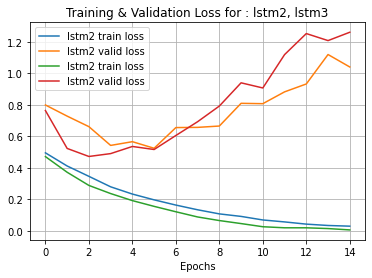

In [385]:
plt.plot(lstm2train, label = 'lstm2 train loss')
plt.plot(lstm2valid, label = 'lstm2 valid loss')
plt.plot(lstm3train, label = 'lstm2 train loss')
plt.plot(lstm3valid, label = 'lstm2 valid loss')
plt.title('Training & Validation Loss for : lstm2, lstm3')
plt.xlabel('Epochs')
plt.grid('on')
plt.legend()
plt.show()

## 5. Improving Model Training

###  B. Model Weight Initialization

[Q7b] What is weight initialization? What potential problem is it trying to prevent from happening? Explain it briefy.

Weight initialization is as it sounds, initializing the model neural networks' weights. By manually setting them, it prevents the model from facing exploding or vanishing gradient problems. Selecting an appropriate initial weight gives a higher chance for the model to converge quickly.

In [390]:
class Xavier7(nn.Module):
  def __init__(self, n_vocab, embedding_dim, hidden_dim, n_layers, dropout = 0):
    super(Xavier7, self).__init__()                    
    self.emb = nn.Embedding(n_vocab, embedding_dim) 
    self.rnn = nn.LSTM(                               
        input_size = embedding_dim,
        hidden_size = hidden_dim,
        num_layers = n_layers,
        batch_first = True
    )
    self.dropout =  nn.Dropout(p = 0.1)
    self.fc = nn.Linear(hidden_dim, 1) 

    # weight initialization using xavier_normal
    nn.init.xavier_normal(self.emb.weight)  
    nn.init.xavier_normal(self.fc.weight) 

  def forward(self, sent, sent_len):     
    sent_emb = self.emb(sent)  
    packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first = True)
    packed_outputs, hidden = self.rnn(packed_embedded)
    out, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first= True)

    out = self.dropout(out)
    out = self.fc(out)
    out = out.view(out.size(0), -1)

    return out

In [391]:
xavier7 = Xavier7(n_vocab, embedding_dim, hidden_dim, n_layers, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(xavier7.parameters())

xavier7train, xavier7valid, xavier7score = Train(xavier7, train_iter, valid_iter, n_epochs, criterion, optimizer, val_loss, device, dropout)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  from ipykernel import kernelapp as app


Start Training
Epoch [1/15], Train Loss: 0.4676, Valid Loss: 0.7010, Valid Acc: 0.3228
Epoch [2/15], Train Loss: 0.2526, Valid Loss: 0.4599, Valid Acc: 0.4803
Epoch [3/15], Train Loss: 0.1606, Valid Loss: 0.4645, Valid Acc: 0.4819
Epoch [4/15], Train Loss: 0.1063, Valid Loss: 0.7001, Valid Acc: 0.4669
Epoch [5/15], Train Loss: 0.0762, Valid Loss: 0.6816, Valid Acc: 0.4772
Epoch [6/15], Train Loss: 0.0549, Valid Loss: 0.8699, Valid Acc: 0.4706
Epoch [7/15], Train Loss: 0.0456, Valid Loss: 1.0243, Valid Acc: 0.4694
Epoch [8/15], Train Loss: 0.0362, Valid Loss: 1.3176, Valid Acc: 0.4613
Epoch [9/15], Train Loss: 0.0313, Valid Loss: 1.2626, Valid Acc: 0.4656
Epoch [10/15], Train Loss: 0.0218, Valid Loss: 1.2768, Valid Acc: 0.4647
Epoch [11/15], Train Loss: 0.0174, Valid Loss: 1.4806, Valid Acc: 0.4625
Epoch [12/15], Train Loss: 0.0204, Valid Loss: 1.1525, Valid Acc: 0.4613
Epoch [13/15], Train Loss: 0.0174, Valid Loss: 1.4146, Valid Acc: 0.4675
Epoch [14/15], Train Loss: 0.0123, Valid Loss

In [392]:
class Kaiming8(nn.Module):
  def __init__(self, n_vocab, embedding_dim, hidden_dim, n_layers, dropout = 0):
    super(Kaiming8, self).__init__()                    
    self.emb = nn.Embedding(n_vocab, embedding_dim) 
    self.rnn = nn.LSTM(                               
        input_size = embedding_dim,
        hidden_size = hidden_dim,
        num_layers = n_layers,
        batch_first = True
    )
    self.dropout =  nn.Dropout(p = 0.1)
    self.fc = nn.Linear(hidden_dim, 1) 

    nn.init.kaiming_normal_(self.emb.weight)  
    nn.init.kaiming_normal_(self.fc.weight) 

  def forward(self, sent, sent_len):

    sent_emb = self.emb(sent)  
    packed_embedded = nn.utils.rnn.pack_padded_sequence(sent_emb, sent_len, batch_first = True)
    packed_outputs, hidden = self.rnn(packed_embedded)
    out, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first= True)

    out = self.dropout(out)
    out = self.fc(out)
    out = out.view(out.size(0), -1)

    return out

In [393]:
kaiming8 = Kaiming8(n_vocab, embedding_dim, hidden_dim, n_layers, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(kaiming8.parameters())

kaiming8train, kaiming8valid, kaiming8score = Train(kaiming8, train_iter, valid_iter, n_epochs, criterion, optimizer, val_loss, device, dropout)

Start Training
Epoch [1/15], Train Loss: 0.4971, Valid Loss: 0.7759, Valid Acc: 0.3134
Epoch [2/15], Train Loss: 0.3196, Valid Loss: 0.5507, Valid Acc: 0.4506
Epoch [3/15], Train Loss: 0.2085, Valid Loss: 0.5336, Valid Acc: 0.4647
Epoch [4/15], Train Loss: 0.1495, Valid Loss: 0.6352, Valid Acc: 0.4600
Epoch [5/15], Train Loss: 0.1047, Valid Loss: 0.7065, Valid Acc: 0.4672
Epoch [6/15], Train Loss: 0.0733, Valid Loss: 0.6623, Valid Acc: 0.4791
Epoch [7/15], Train Loss: 0.0565, Valid Loss: 0.9899, Valid Acc: 0.4697
Epoch [8/15], Train Loss: 0.0429, Valid Loss: 1.0065, Valid Acc: 0.4663
Epoch [9/15], Train Loss: 0.0323, Valid Loss: 1.1838, Valid Acc: 0.4716
Epoch [10/15], Train Loss: 0.0252, Valid Loss: 1.2429, Valid Acc: 0.4666
Epoch [11/15], Train Loss: 0.0184, Valid Loss: 1.4350, Valid Acc: 0.4697
Epoch [12/15], Train Loss: 0.0221, Valid Loss: 1.4555, Valid Acc: 0.4650
Epoch [13/15], Train Loss: 0.0159, Valid Loss: 1.5772, Valid Acc: 0.4663
Epoch [14/15], Train Loss: 0.0139, Valid Loss

[Q8b] Plot the training and validation losses of model 2, model 7, and model 8 in one plot and
report the best validation accuracy of each model.

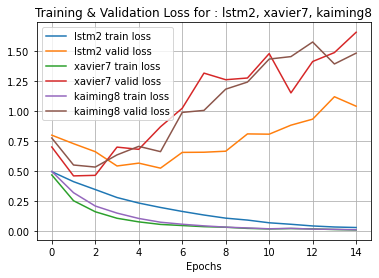

In [394]:
plt.plot(lstm2train, label = 'lstm2 train loss')
plt.plot(lstm2valid, label = 'lstm2 valid loss')
plt.plot(xavier7train, label = 'xavier7 train loss')
plt.plot(xavier7valid, label = 'xavier7 valid loss')
plt.plot(kaiming8train, label = 'kaiming8 train loss')
plt.plot(kaiming8valid, label = 'kaiming8 valid loss')
plt.title('Training & Validation Loss for : lstm2, xavier7, kaiming8')
plt.xlabel('Epochs')
plt.grid('on')
plt.legend()
plt.show()

[Q9b] From the above results, does weight initialization aect model training in terms of con-
vergence rate and model performance in terms of validation accuracy? If yes, describe the
dierence(s). If no, suggest some possible reason(s).

As observed from the above graph, xavier7 and kaiming8 model converges relatively quicker than lstm2 model. However, the best validation accuracy hasn't shown improvement. It is plausible that the weights have been moderately setted for lstm2 model, making weight initialization for these models impactless.

### D. Model Ensemble

[Q7d] Why does the model ensemble improve the performance of the model?

Ensemble method combines several models of choice, producing an output that has taken into account all the results of the chosen models. Ensembling models reduce the variance of the predictions, hence increasing the accuracy of the composite models. There are several different variants of ensemble learning, and in pa3, average ensemble and weighted average ensemble techniques will be implemented.

[Q8d] Propose a method to find suitable weights for the models in the weighted average ensemble.

The first intuitive method will be to brute search the weights for each model(sum of weights = 1) and utilize the weight set with the lowest validation loss. 

Out of many other possible methods, one plausible method will be to weight them with respect to their ranks (i.e. best validation score). The normalized validation score will be the precise weights for each model.

In [423]:
PRE_THRESH = 0.5    # pre define a constant threshold 0.5

def Ensemble_Train(model_list, train_loader, valid_loader, n_epochs, criterion, val_loss, device, save_name):
  if val_loss==None:
    best_val_loss = float("Inf")  
  else: 
    best_val_loss=val_loss
    print('Resume training')

  model1, optim1 = model_list[0]
  print(model1)
  #print(optim1)
  model2, optim2 = model_list[1]
  print(model2)
  #print(optim2)
  model3, optim3 = model_list[2]
  print(model3)
    
  print("Start Training")
  train_loss_score = []
  valid_loss_score = []
  best_val_score = 0

  for epoch in range(n_epochs):
    model1.train()
    model2.train()
    model3.train()
    running_loss = 0.0

    for data in train_loader:
      label = data.label
      input, sen_len = data.sentence
      label = label.to(device)
      input = input.to(device)

      ''' Model Train Step'''
      # Forward
      output1 = model1(input, sen_len)
      output1 = torch.mean(output1, 1) 
      loss1 = criterion(output1, label.float())
      running_loss += loss1.item()

      output2 = model2(input, sen_len)
      output2 = torch.mean(output2, 1) 
      loss2 = criterion(output2, label.float())
      running_loss += loss2.item()

      output3 = model3(input, sen_len)
      output3 = torch.mean(output3, 1) 
      loss3 = criterion(output3, label.float())
      running_loss += loss3.item()

      # Backward
      optim1.zero_grad()
      loss1.backward()
      optim1.step()

      optim2.zero_grad()
      loss2.backward()
      optim2.step()

      optim3.zero_grad()
      loss3.backward()
      optim3.step()

    train_loss = running_loss / (len(train_loader) *3)
    train_loss_score.append(train_loss)

    with torch.no_grad():
      model1.eval()
      model2.eval()
      model3.eval()

      valid_running_loss = 0.0
      correct_count = 0
      for data in valid_loader:
        label = data.label
        input, sen_len = data.sentence
        label = label.to(device)
        input = input.to(device)

        ''' Model Train Step'''
        # eval
        output1 = model1(input, sen_len)
        output1 = torch.mean(output1, 1)
        loss1 = criterion(output1, label.float())
        valid_running_loss += loss1.item()

        output2 = model2(input, sen_len)
        output2 = torch.mean(output2, 1)
        loss2 = criterion(output2, label.float())
        valid_running_loss += loss2.item()

        output3 = model3(input, sen_len)
        output3 = torch.mean(output3, 1)
        loss3 = criterion(output3, label.float())
        valid_running_loss += loss3.item()

        output = output1 + output2 + output3
        output = output / 3
        prediction = output >= torch.FloatTensor([PRE_THRESH]).to(device)
        correct_prediction = prediction.float() == label
        correct_count += torch.sum(correct_prediction) 

      valid_loss = valid_running_loss / (len(valid_loader) *3 )
      valid_loss_score.append(valid_loss)
      accuracy = correct_count / len(valid_loader)
      if accuracy > best_val_score:
        best_val_score = accuracy

      print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'
      .format(epoch+1, n_epochs, train_loss, valid_loss, accuracy / 100))

    # if valid_loss < best_val_loss:
    #           best_val_loss = valid_loss
    #           save_checkpoint(save_name, model, optimizer, best_val_loss)
                  
  print('Finished Training')
  print('Best Validation Accuracy Score: {:.4f}', best_val_score.item() / 100)
  return train_loss_score, valid_loss_score, best_val_score.item()/ 100


Finding three best models (in terms of validation accuracy)

In [408]:
print('rnn0score:', rnn0score)
print('gru1score:', gru1score)
print('lstm2score:', lstm2score)
print('lstm3score:', lstm3score)
print('xavier7score:', xavier7score)
print('kaiming8score:', kaiming8score)

rnn0score: 0.4846875
gru1score: 0.4890625
lstm2score: 0.483125
lstm3score: 0.5
xavier7score: 0.481875
kaiming8score: 0.4790625


Bi-directional LSTM3, GRU1 and RNN0 scored the top 3 validation accuracy.

In [424]:
rnn0 = RNN0(n_vocab, embedding_dim, hidden_dim, n_layers, dropout)
optimizer0 = Adam(rnn0.parameters())
gru1 = GRU1(n_vocab, embedding_dim, hidden_dim, n_layers, dropout)
optimizer1 = Adam(gru1.parameters())
lstm3 = LSTM3(n_vocab, embedding_dim, hidden_dim, n_layers, dropout)
optimizer3 = Adam(lstm3.parameters())

model_list = [(rnn0, optimizer0), (gru1, optimizer1), (lstm3, optimizer3)]
ensemble15train, ensemble15valid, ensemble15score = Ensemble_Train(model_list, train_iter, valid_iter, n_epochs, criterion, val_loss, device, dropout)

RNN0(
  (emb): Embedding(7929, 50)
  (rnn): RNN(50, 64, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
GRU1(
  (emb): Embedding(7929, 50)
  (rnn): GRU(50, 64, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
LSTM3(
  (emb): Embedding(7929, 50)
  (rnn): LSTM(50, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
Start Training
Epoch [1/15], Train Loss: 0.4834, Valid Loss: 0.7706, Valid Acc: 0.3169
Epoch [2/15], Train Loss: 0.3914, Valid Loss: 0.6261, Valid Acc: 0.3925
Epoch [3/15], Train Loss: 0.3217, Valid Loss: 0.6737, Valid Acc: 0.4150
Epoch [4/15], Train Loss: 0.2714, Valid Loss: 0.5995, Valid Acc: 0.4569
Epoch [5/15], Train Loss: 0.2279, Valid Loss: 0.5516, Valid Acc: 0.4787
Epoch [6/15], Train Loss: 0.1940, Valid Loss: 0.5102, Valid Acc: 0.4922

In [428]:
PRE_THRESH = 0.5    # pre define a constant threshold 0.5

def Weight_Ensemble_Train(model_list, weight, train_loader, valid_loader, n_epochs, criterion, val_loss, device, save_name):
  if val_loss==None:
    best_val_loss = float("Inf")  
  else: 
    best_val_loss=val_loss
    print('Resume training')

  model1, optim1 = model_list[0]
  model2, optim2 = model_list[1]
  model3, optim3 = model_list[2]
    
  print("Start Training")
  train_loss_score = []
  valid_loss_score = []
  best_val_score = 0

  for epoch in range(n_epochs):
    model1.train()
    model2.train()
    model3.train()
    running_loss = 0.0

    for data in train_loader:
      label = data.label
      input, sen_len = data.sentence
      label = label.to(device)
      input = input.to(device)

      ''' Model Train Step'''
      # Forward
      output1 = model1(input, sen_len)
      output1 = torch.mean(output1, 1) 
      loss1 = criterion(output1, label.float())
      running_loss += loss1.item() * weight[0]

      output2 = model2(input, sen_len)
      output2 = torch.mean(output2, 1) 
      loss2 = criterion(output2, label.float())
      running_loss += loss2.item() * weight[1]

      output3 = model3(input, sen_len)
      output3 = torch.mean(output3, 1) 
      loss3 = criterion(output3, label.float())
      running_loss += loss3.item() * weight[2]

      # Backward
      optim1.zero_grad()
      loss1.backward()
      optim1.step()

      optim2.zero_grad()
      loss2.backward()
      optim2.step()

      optim3.zero_grad()
      loss3.backward()
      optim3.step()

    train_loss = running_loss / len(train_loader)
    train_loss_score.append(train_loss)

    with torch.no_grad():
      model1.eval()
      model2.eval()
      model3.eval()

      valid_running_loss = 0.0
      correct_count = 0
      for data in valid_loader:
        label = data.label
        input, sen_len = data.sentence
        label = label.to(device)
        input = input.to(device)

        ''' Model Train Step'''
        # eval
        output1 = model1(input, sen_len)
        output1 = torch.mean(output1, 1) * weight[0]
        loss1 = criterion(output1, label.float())
        valid_running_loss += loss1.item() * weight[0]

        output2 = model2(input, sen_len)
        output2 = torch.mean(output2, 1) * weight[1]
        loss2 = criterion(output2, label.float())
        valid_running_loss += loss2.item() * weight[1]

        output3 = model3(input, sen_len)
        output3 = torch.mean(output3, 1)* weight[2]
        loss3 = criterion(output3, label.float())
        valid_running_loss += loss3.item() * weight[2]

        output = output1 + output2 + output3
        prediction = output >= torch.FloatTensor([PRE_THRESH]).to(device)
        correct_prediction = prediction.float() == label
        correct_count += torch.sum(correct_prediction) 

      valid_loss = valid_running_loss / (len(valid_loader) *3 )
      valid_loss_score.append(valid_loss)
      accuracy = correct_count / len(valid_loader)
      if accuracy > best_val_score:
        best_val_score = accuracy

      print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'
      .format(epoch+1, n_epochs, train_loss, valid_loss, accuracy / 100))

    # if valid_loss < best_val_loss:
    #           best_val_loss = valid_loss
    #           save_checkpoint(save_name, model, optimizer, best_val_loss)
                  
  print('Finished Training')
  print('Best Validation Accuracy Score: {:.4f}', best_val_score.item() / 100)
  return train_loss_score, valid_loss_score, best_val_score.item()/ 100


In [429]:
scores = [rnn0score, gru1score, lstm3score]
weight_scores = [float(i) / np.sum(scores) for i in scores]
weight_scores

[0.328880407124682, 0.33184902459711624, 0.3392705682782019]

In [430]:
rnn0 = RNN0(n_vocab, embedding_dim, hidden_dim, n_layers, dropout)
optimizer0 = Adam(rnn0.parameters())
gru1 = GRU1(n_vocab, embedding_dim, hidden_dim, n_layers, dropout)
optimizer1 = Adam(gru1.parameters())
lstm3 = LSTM3(n_vocab, embedding_dim, hidden_dim, n_layers, dropout)
optimizer3 = Adam(lstm3.parameters())

model_list = [(rnn0, optimizer0), (gru1, optimizer1), (lstm3, optimizer3)]
ensemble16train, ensemble16valid, ensemble16score = Weight_Ensemble_Train(model_list, weight_scores, train_iter, valid_iter, n_epochs, criterion, val_loss, device, dropout)


Start Training
Epoch [1/15], Train Loss: 0.4836, Valid Loss: 0.2223, Valid Acc: 0.3200
Epoch [2/15], Train Loss: 0.3964, Valid Loss: 0.2039, Valid Acc: 0.3809
Epoch [3/15], Train Loss: 0.3272, Valid Loss: 0.1900, Valid Acc: 0.4253
Epoch [4/15], Train Loss: 0.2715, Valid Loss: 0.1768, Valid Acc: 0.4634
Epoch [5/15], Train Loss: 0.2285, Valid Loss: 0.1724, Valid Acc: 0.4628
Epoch [6/15], Train Loss: 0.1903, Valid Loss: 0.1687, Valid Acc: 0.4691
Epoch [7/15], Train Loss: 0.1586, Valid Loss: 0.1599, Valid Acc: 0.4878
Epoch [8/15], Train Loss: 0.1257, Valid Loss: 0.1579, Valid Acc: 0.4853
Epoch [9/15], Train Loss: 0.1009, Valid Loss: 0.1547, Valid Acc: 0.4938
Epoch [10/15], Train Loss: 0.0786, Valid Loss: 0.1579, Valid Acc: 0.4919
Epoch [11/15], Train Loss: 0.0629, Valid Loss: 0.1601, Valid Acc: 0.4925
Epoch [12/15], Train Loss: 0.0495, Valid Loss: 0.1656, Valid Acc: 0.4891
Epoch [13/15], Train Loss: 0.0372, Valid Loss: 0.1658, Valid Acc: 0.4941
Epoch [14/15], Train Loss: 0.0267, Valid Loss

## 6. Prediction
### [P1] p1.csv

In [431]:
print('rnn0score:', rnn0score)
print('gru1score:', gru1score)
print('lstm2score:', lstm2score)
print('lstm3score:', lstm3score)
print('xavier7score:', xavier7score)
print('kaiming8score:', kaiming8score)
print('ensemble15score:', ensemble15score)
print('ensemble16score:', ensemble16score)

rnn0score: 0.4846875
gru1score: 0.4890625
lstm2score: 0.483125
lstm3score: 0.5
xavier7score: 0.481875
kaiming8score: 0.4790625
ensemble15score: 0.5009375
ensemble16score: 0.4940625


In [433]:
with torch.no_grad():
  model.eval()
  prediction_list = []
  for data in test_iter:
    label = data.label
    input, sen_len = data.sentence

    prediction = lstm3(input, sen_len)
    prediction = torch.mean(prediction, 1) 
    prediction = prediction >= torch.FloatTensor([PRE_THRESH]).to(device)
    prediction = prediction.gt(0).to(torch.int).cpu().detach().numpy()
    
    for index in range(len(prediction)):
            prediction_list.append(prediction[index])

len(prediction_list) 

2000

In [434]:
test = pd.read_csv(PATH + 'test.csv')
test['label'] = prediction_list
test.head()
test.to_csv(PATH + '20308109_pred.csv', index = False)